## Multilinear / Multi-variate / mulit-variable Regression  

In [1]:
import kagglehub
import pandas as pd
import numpy  as np

In [2]:
path = kagglehub.dataset_download("thedevastator/books-sales-and-ratings")

In [3]:
booksales = pd.read_csv(path+'/Books_Data_Clean.csv')

In [4]:
booksales.head()

,index,Publishing Year,Book Name,Author,language_code,Author_Rating,Book_average_rating,Book_ratings_count,genre,gross sales,publisher revenue,sale price,sales rank,Publisher,units sold
0,0,1975.0,Beowulf,"Unknown, Seamus Heaney",en-US,Novice,3.42,155903,genre fiction,34160.0,20496.0,4.88,1,HarperCollins Publishers,7000
1,1,1987.0,Batman: Year One,"Frank Miller, David Mazzucchelli, Richmond Lew...",eng,Intermediate,4.23,145267,genre fiction,12437.5,7462.5,1.99,2,HarperCollins Publishers,6250
2,2,2015.0,Go Set a Watchman,Harper Lee,eng,Novice,3.31,138669,genre fiction,47795.0,28677.0,8.69,3,"Amazon Digital Services, Inc.",5500
3,3,2008.0,When You Are Engulfed in Flames,David Sedaris,en-US,Intermediate,4.04,150898,fiction,41250.0,24750.0,7.50,3,Hachette Book Group,5500
4,4,2011.0,Daughter of Smoke & Bone,Laini Taylor,eng,Intermediate,4.04,198283,genre fiction,37952.5,22771.5,7.99,4,Penguin Group (USA) LLC,4750


### Look at correlation between variables  
We want to use independent variables in multi-linear regression.

In [5]:
import seaborn as sb

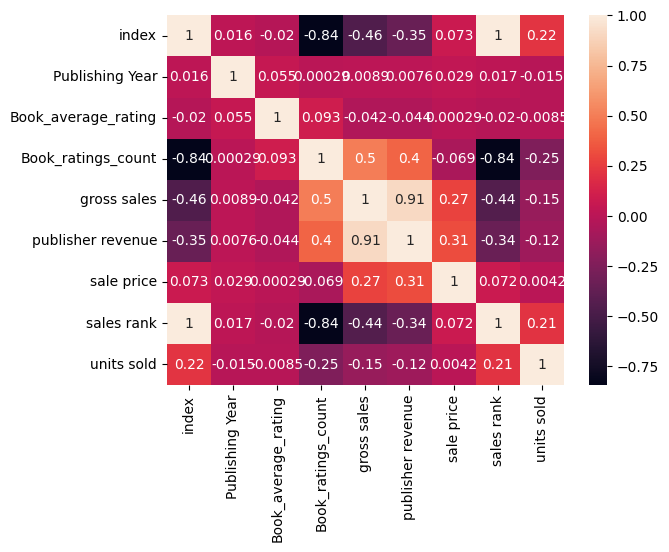

In [6]:
dataplot = sb.heatmap(booksales.corr(numeric_only=True), annot=True) # , cmap="YlGnBu"

I want to predict the gross sales. The variables most correlated with gross sales are: book average ratings, publisher revenue, and sale price. I'm only going to use book ratings and sale price, because publisher revenue is almost too correlated with gross sales.

In [7]:
columns = ['Book_average_rating', 'sale price', 'gross sales']

print(len(booksales))

booksales = booksales.dropna(subset=columns)
booksales = booksales[booksales['Book_average_rating'] > 0.5]
booksales = booksales[booksales['gross sales'] < 3000] # to predict a subset

print(len(booksales))

1070
936


In [8]:
import torch

In [9]:
book_ratings = booksales['Book_average_rating']
sale_price   = booksales['sale price']
gross_sales  = booksales['gross sales']

x__book_ratings = torch.tensor( data = book_ratings.values, dtype = torch.float )
x__sale_price   = torch.tensor( data = sale_price.values,   dtype = torch.float )
y__gross_sales  = torch.tensor( data = gross_sales.values,  dtype = torch.float ) # target

In [10]:
def normalise(val):
    mean = val.mean()
    std  = val.std()
    normalised = (val - mean) / std
    return normalised, mean, std

In [11]:
x__book_ratings, br_mean, br_std = normalise(x__book_ratings)
x__sale_price, sp_mean, sp_std   = normalise(x__sale_price)
y__gross_sales, gs_mean, gs_std  = normalise(y__gross_sales)

https://www.kaggle.com/code/joseguzman/multiple-regression-explained-with-pytorch

In [12]:
# coefficients to update during training - requires_grad = True so PyTorch updates them

a = torch.randn(1, requires_grad = True)  # start with a random number from a normal distribution
b = torch.randn(1, requires_grad = True)
c = torch.randn(1, requires_grad = True)

In [13]:
def multilinear_model( rating : torch.Tensor, price : torch.Tensor):
    return a + b*rating + c*price

In [14]:
# generate the first prediction
predicted = multilinear_model(x__book_ratings, x__sale_price)
predicted.shape

torch.Size([936])

In [15]:
y__gross_sales.shape

torch.Size([936])

In [16]:
def meansquarederror(y_predicted : torch.Tensor, y_target : torch.Tensor):
    error = y_predicted - y_target # element-wise substraction
    return torch.sum(error**2 ) / error.numel() # mean (sum/n)

In [17]:
predicted = multilinear_model(x__book_ratings, x__sale_price)
loss      = meansquarederror(y_predicted = predicted, y_target=y__gross_sales)
print(loss)

tensor(1.6788, grad_fn=<DivBackward0>)


In [18]:
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt

100%|██████████| 15000/15000 [00:07<00:00, 1915.60it/s]


(Text(0.5, 0, 'Epoch (#)'), Text(0, 0.5, 'Mean squared Errors'))

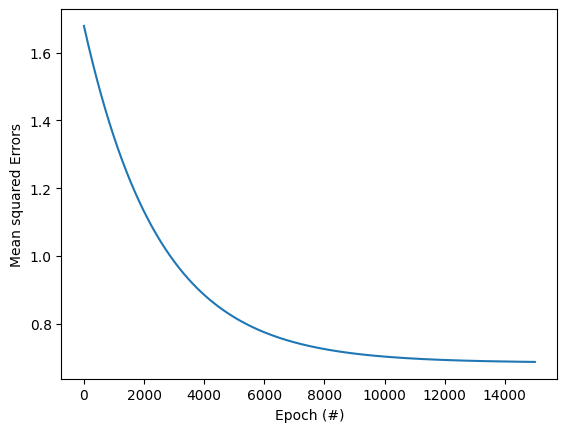

In [19]:
myMSE     = list()
optimizer = torch.optim.SGD([a, b, c], lr=1e-4)

for i in tqdm(range(15_000)):
    optimizer.zero_grad()
    
    predicted = multilinear_model(x__book_ratings, x__sale_price) # forward pass (compute results)
    loss      = meansquarederror(y_predicted = predicted, y_target=y__gross_sales) # calculate MSE
    
    loss.backward() # compute gradients
    myMSE.append(loss.item()) # append loss
    optimizer.step() # update parameters
        
plt.plot(myMSE)
plt.xlabel('Epoch (#)'), plt.ylabel('Mean squared Errors')

In [20]:
y_actual = y__gross_sales * gs_std + gs_mean
y_pred   = predicted.detach() * gs_std + gs_mean

(0.0, 3300.0000000000005)

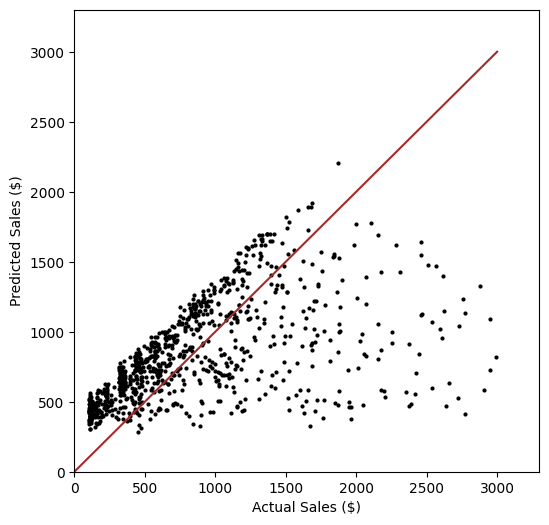

In [21]:
# Create the plot
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred, c='k', s=4)
plt.xlabel('Actual Sales ($)'), plt.ylabel('Predicted Sales ($)')

max_val = 3000 #max(y_actual.max(), y_pred.max())
x = y = np.linspace(0, max_val, 100)
plt.plot(x, y, c='brown')
plt.xlim(0, max_val * 1.1)
plt.ylim(0, max_val * 1.1)

It is unexpected that the model is unable to predict well the gross sales from these variables, as the dataset contains a lot of variance and likely isn't best modelled using a linear relationship. But it was a nice dataset I had access to so I used it for this.